In [1]:
#!pip show tensorflow_datasets
!pip3 install emnist
!pip3 install tensorflow_datasets
!pip3 install opencv_python
!pip3 install matplotlib
!pip3 install chardet
!pip3 install pandas

In [2]:
# import emnist
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import sklearn
from sklearn.decomposition import PCA 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
import cv2
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
%matplotlib inline
# tf.debugging.set_log_device_placement(False)

In [3]:
print(tf.config.list_physical_devices('GPU'))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
print(tf.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0
True


In [4]:
(ds_train, ds_test), info = tfds.load('omniglot', split=['train', 'test'], with_info=True)

In [5]:
df_train = tfds.as_dataframe(ds_train, info)
df_test  = tfds.as_dataframe(ds_test, info)

In [6]:
train_images = np.stack(df_train['image'])
train_images.shape

(19280, 105, 105, 3)

In [7]:
df_train.columns

Index(['alphabet', 'alphabet_char_id', 'image', 'label'], dtype='object')

In [8]:
len(df_train['label'].unique())

964

In [9]:
#df_train[['alphabet_char_id', 'label']].loc[np.where((df_train['alphabet'] == 27) & (df_train['alphabet_char_id'] == 23))]

In [10]:
''' Data handling general functions '''

def separate_fewshot(test_images, test_labels, n=1):
    oneshot_data = []
    classify_data = []
    for label in np.unique(test_labels):
        for num in np.random.choice(np.where(test_labels == label)[0], n, False):
            oneshot_data.append(num)
    temp = set(oneshot_data)
    for i in range(len(test_labels)):
        if not i in temp: classify_data.append(i)
    oneshot_images = test_images[oneshot_data]
    oneshot_labels = test_labels[oneshot_data]
    classify_images = test_images[classify_data]
    classify_labels = test_labels[classify_data]
    return oneshot_images, oneshot_labels, classify_images, classify_labels

In [11]:
def resize_images(images, size, to_grayscale = True):
    resized_images = []
    for img in images:
        resized_image = cv2.resize(img, (size, size))
        if to_grayscale:
            resized_image= cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        resized_images.append(resized_image)
    return np.array(resized_images)

In [12]:
def parse_omniglot_dataframe(df, img_size = 56):
    images = resize_images(df['image'], img_size)
    images = images.reshape(-1, img_size * img_size)
    labels = df['label'].to_numpy()
    return (images, labels)

In [13]:
img, lbl = parse_omniglot_dataframe(df_test)
img.shape

(13180, 3136)

In [14]:
def test_PCA(df_train, df_test, n=1, n_components = 32, verbose=False, train=1):
    
    (train_images, train_labels) = parse_omniglot_dataframe(df_train)
    (test_images, test_labels) = parse_omniglot_dataframe(df_test)
    t_alphabets = df_test['alphabet'].to_numpy()
    
    if verbose: print("======= PCA method: Training and evaluating ... =======")
    if verbose: print("Learning background ...")
    pca = PCA(n_components=n_components)
    pca.fit(X=train_images)
    
    matches = 0
    total = 0
    
    if verbose: print("Vectorizing ...")
    for alphabet in np.unique(t_alphabets):
        ind_alphabet = np.where(t_alphabets == alphabet)[0]
        labels = test_labels[ind_alphabet]
        images = test_images[ind_alphabet]
        os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=n)
        
        
        os_img = pca.transform(os_img)
        clas_img = pca.transform(clas_img)

        #if verbose: print("Learning oneshot ...")
        nn = min(train, 5)
        neigh = KNeighborsClassifier(n_neighbors = nn)
        neigh.fit(os_img, os_label)

        #if verbose: print("Predicting ...")
        pred = neigh.predict(clas_img)
        
        matches += np.sum(pred == clas_label)
        total += len(clas_label)
        
    if verbose:
        print("Accuracy: ", matches/total)
        print("======= PCA method: Finished =======")

    return matches/total

In [15]:
# test_PCA(df_train, df_test, verbose=True)

In [16]:
def test_LDA(df_train, df_test, n=1, n_components = 32, verbose=False, train=1, c=3):
    
    (train_images, train_labels) = parse_omniglot_dataframe(df_train)
    (test_images, test_labels) = parse_omniglot_dataframe(df_test)
    t_alphabets = df_test['alphabet'].to_numpy()
    
    # unique_labels = df_train['label'].unique()
    # subsample_index = []
    # for label in unique_labels:
    #     for ind in np.random.choice(np.where(df_train['label'] == label)[0], c, False):
    #         subsample_index.append(ind)
    # subsample_index = np.array(subsample_index)
    # train_images = train_images[subsample_index]
    # train_labels = train_labels[subsample_index]
    
    if verbose: print("======= LDA method: Training and evaluating ... =======")
    if verbose: print("Learning background ...")
    lda = LDA(n_components=n_components)
    lda.fit(X=train_images,y=train_labels)
    
    matches = 0
    total = 0
    
    if verbose: print("Vectorizing ...")
    for alphabet in np.unique(t_alphabets):
        ind_alphabet = np.where(t_alphabets == alphabet)[0]
        labels = test_labels[ind_alphabet]
        images = test_images[ind_alphabet]
        os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=n)
        
        
        os_img = lda.transform(os_img)
        clas_img = lda.transform(clas_img)

        #if verbose: print("Learning oneshot ...")
        nn = min(train, 5)
        neigh = KNeighborsClassifier(n_neighbors = nn)
        neigh.fit(os_img, os_label)

        #if verbose: print("Predicting ...")
        pred = neigh.predict(clas_img)
        
        matches += np.sum(pred == clas_label)
        total += len(clas_label)
        
    if verbose:
        print("Accuracy: ", matches/total)
        print("======= LDA method: Finished =======")

    return matches/total

In [17]:
# test_LDA(df_train, df_test, verbose=True,c=6)

In [134]:
def nonlinear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder
    """
    encoder = keras.Sequential([
        keras.layers.Dense(input_size//4, activation='ReLU'),
        keras.layers.Dense(code_size),
    ])
    
    decoder = keras.Sequential([
        keras.layers.Dense(input_size//4, activation='ReLU'),
        keras.layers.Dense(input_size),
    ])
    
    inputs = keras.Input(shape=(input_size,))
    outputs = decoder(encoder(inputs))
    autoencoder = keras.Model(inputs=inputs, outputs=outputs)
    
    autoencoder.compile(optimizer='Adam', loss='MSE')
    return autoencoder, encoder

def linear_autoencoder(input_size, code_size: int):
    """
    Instanciate and compiles an autoencoder, returns both the autoencoder and just the encoder
    """
    encoder = keras.Sequential([
        keras.layers.Dense(code_size),
    ])
    
    decoder = keras.Sequential([
        keras.layers.Dense(input_size),
    ])
    
    inputs = keras.Input(shape=(input_size,))
    outputs = decoder(encoder(inputs))
    autoencoder = keras.Model(inputs=inputs, outputs=outputs)
    
    autoencoder.compile(optimizer='Adam', loss='MSE')
    return autoencoder, encoder

In [135]:
def test_autoencoder(df_train, df_test, autoencoder, img_size=56, num_components=32, n=1, verbose=False, train=1):
    
    (train_images, train_labels) = parse_omniglot_dataframe(df_train, img_size)
    (test_images, test_labels) = parse_omniglot_dataframe(df_test, img_size)
    t_alphabets = df_test['alphabet'].to_numpy()
        
    if verbose: print("======= NL Autoencoder method: Training and evaluating ... =======")
    if verbose: print("Learning background ...")
    autoencoder, encoder = autoencoder(img_size * img_size, code_size=num_components)
    autoencoder.fit(x=train_images,y=train_images, epochs=50, batch_size=64)
    
    matches = 0
    total = 0
    
    if verbose: print("Vectorizing ...")
    for alphabet in np.unique(t_alphabets):
        ind_alphabet = np.where(t_alphabets == alphabet)[0]
        labels = test_labels[ind_alphabet]
        images = test_images[ind_alphabet]
        os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=n)
        
        os_img = encoder.predict(os_img)
        clas_img = encoder.predict(clas_img)

        #if verbose: print("Learning oneshot ...")
        nn = min(train, 5)
        neigh = KNeighborsClassifier(n_neighbors = nn)
        neigh.fit(os_img, os_label)

        #if verbose: print("Predicting ...")
        pred = neigh.predict(clas_img)
        
        matches += np.sum(pred == clas_label)
        total += len(clas_label)
        
    if verbose:
        print("Accuracy: ", matches/total)
        print("======= NL Autoencoder method: Finished =======")

    return matches/total

In [136]:
# test_autoencoder(df_train, df_test, autoencoder=nonlinear_autoencoder, verbose=True)

In [150]:
def get_siamese_net_and_encoder(input_shape, code_size = 0):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    encoder = Sequential()
    encoder.add(Conv2D(64, (10, 10), input_shape=input_shape, activation='relu', kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2))
    encoder.add(Dropout(0.25))
    
    encoder.add(Conv2D(128, (7, 7), kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2))
    encoder.add(Dropout(0.25))
    
    encoder.add(Conv2D(128, (4, 4), kernel_regularizer='l2'))
    encoder.add(BatchNormalization())
    encoder.add(Activation('relu'))
    encoder.add(MaxPooling2D(pool_size=2))
    encoder.add(Dropout(0.25))
    #encoder.add(Conv2D(256, (4, 4), kernel_regularizer='l2'))
    
    encoder.add(Flatten())
    
    encoder.add(Dense(2048, activation='sigmoid', kernel_regularizer='l2'))
    
    left_emb = encoder(left_input)
    right_emb = encoder(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1, activation='sigmoid', kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input, right_input], outputs=OP)
    
    return siamese_net, encoder


In [157]:
IMG_SIZE = 56

(train_images, train_labels) = resize_images(df_train['image'], IMG_SIZE), df_train['label'].to_numpy()

t_alphabets = df_test['alphabet'].to_numpy()

print(train_images.shape)
_, w, h = train_images.shape

siamese_net, encoder = get_siamese_net_and_encoder((w, h, 1))

siamese_net.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

siamese_net.summary()

(19280, 56, 56)
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 2048)         1722176     ['input_13[0][0]',               
                                                                  'input_14[0][0]']               
                                                                                                  
 lambda_6 (Lambda)              (None, 2048)         0           ['sequentia

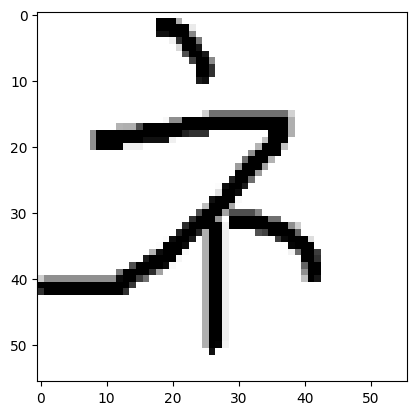

In [158]:
plt.imshow(train_images[0], cmap="gray")

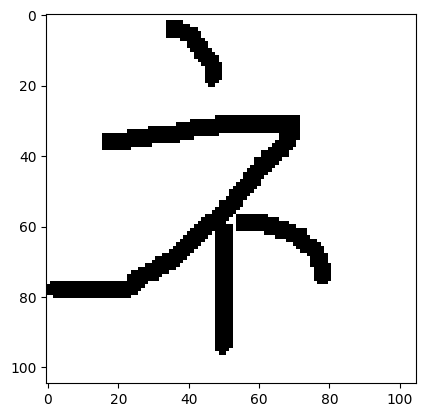

In [159]:
plt.imshow(df_train['image'][0])

In [160]:
def get_image_by_label(label, train_images, train_labels):
    return train_images[np.random.choice(np.where(train_labels == label)[0], 1, False)[0]]

def get_train_data(size, train_images, train_labels, img_size):
    targets = np.zeros((size,))
    targets[size // 2:] = 1
    pairs = [np.zeros((size, img_size, img_size)) for _ in range(2)]
    labels = np.unique(train_labels)
    for i in range(size):
        class1 = np.random.choice(labels, 1)[0]
        class2 = class1
        if i < size // 2:
            while class2 == class1:
                class2 = np.random.choice(labels, 1)[0]
        pairs[0][i] = get_image_by_label(class1, train_images, train_labels)
        pairs[1][i] = get_image_by_label(class2, train_images, train_labels)
    return pairs, targets

def get_train_batch(train_images, train_labels, n_classes, n_shots, n_support, n_iterations, img_size=56):
    labels = np.unique(train_labels)
    num_labels = labels.shape[0]
    np.random.shuffle(labels)
    
    x, y = np.zeros((n_classes * n_shots, img_size, img_size)), np.zeros((n_classes * n_support, img_size, img_size))
    x_l, y_l = np.zeros(n_classes * n_shots), np.zeros(n_classes * n_support)
    
    size = n_classes * n_classes * n_shots * n_support
    n_iterations = min(n_iterations, (num_labels + n_classes - 1) // n_classes)
    
    pairs = [[None for _ in range(size * n_iterations)], [None for _ in range(size * n_iterations)]]
    target = np.zeros(size * n_iterations)
    
    cur = 0
    for t in range(0, n_iterations * n_classes, n_classes):
        classes = labels[t: t + n_classes]
        #classes = np.random.choice(labels, n_classes, False)        
        for i, c in enumerate(classes):
            ind = np.where(train_labels == c)[0]
            ind = np.random.choice(ind, n_shots + n_support, False)

            x_ind = ind[:n_shots]
            x[i * n_shots: (i+1) * n_shots, :] = train_images[x_ind]
            x_l[i * n_shots: (i+1) * n_shots] = train_labels[x_ind]

            y_ind = ind[n_shots:]
            y[i * n_support: (i+1) * n_support, :] = train_images[y_ind]
            y_l[i * n_support: (i+1) * n_support] = train_labels[y_ind]
        for i, xx in enumerate(x):
            if x_l[i] not in classes:
                continue
            for j, yy in enumerate(y):
                if y_l[j] not in classes:
                    continue
                pairs[0][cur] = xx
                pairs[1][cur] = yy
                target[cur] = ((x_l[i] == y_l[j]) and (x_l[i] != -1))
                cur += 1
    pairs[0] = np.array(pairs[0][:cur])
    pairs[1] = np.array(pairs[1][:cur])
    target = target[:cur]
    return pairs, target

def visualize_siamese(siamese_net, train_images, train_labels, label1 = 1, label2=2):
    x = train_images[np.where(train_labels == label1)[0][:1]]
    y = train_images[np.where(train_labels == label2)[0][1:2]]
    d = siamese_net.predict([x, y], verbose=0)
    fig, axis = plt.subplots(1, 2, figsize=(10, 5))
    axis[0].axis("off")
    axis[1].axis("off")
    fig.suptitle(f"Output {d[0][0]}")
    axis[0].imshow(x[0], cmap='gray')
    axis[1].imshow(y[0], cmap='gray')
    plt.show()

In [167]:
num_iterations = 20
num_iterations_alphabet = 1000
batch_size = 62
evaluateEvery = 200
num_shots = 1
IMG_SIZE = 56
n_support = 5
n_classes = 10
num_labels = np.unique(train_labels).shape[0]
n_iterations = 30

In [172]:
def train_one_shot():
    for i in range(1, num_iterations + 1):
        print(f"Epoch {i}:")
        x, y = get_train_batch(train_images, train_labels, n_classes=n_classes, n_shots=num_shots, n_support=5, n_iterations=n_iterations, img_size=IMG_SIZE)
        #print("shapes:", x[0].shape, x[1].shape, y.shape)
        #print("sum is:", np.sum(y), "should be:", n_iterations * n_classes * num_shots * n_support)
        loss = siamese_net.fit(x, y, batch_size=batch_size,)
        #if i % evaluateEvery == 0:
        #    print('Iteration', i, '- Loss:',loss[0],'- Acc:', round(loss[1], 2))
train_one_shot()

Epoch 1:
242/242 [==============================] - 5s 21ms/step - loss: 0.1772 - accuracy: 0.9935
Epoch 2:
242/242 [==============================] - 5s 21ms/step - loss: 0.2005 - accuracy: 0.9914
Epoch 3:
242/242 [==============================] - 5s 21ms/step - loss: 0.2584 - accuracy: 0.9903
Epoch 4:
242/242 [==============================] - 5s 21ms/step - loss: 0.2909 - accuracy: 0.9864
Epoch 5:


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [164]:
def train_per_alphabet():
    alphabets = np.unique(df_train['alphabet'])
    info_alphabet = {}
    for alphabet in alphabets:
        ind = np.where(df_train['alphabet'] == alphabet)[0]
        #print(train_images[ind].shape, ind.shape, train_images.shape)
        info_alphabet[alphabet] = (train_images[ind], train_labels[ind])

    for i in range(1, num_iterations_alphabet + 1):
        loss = 0
        for alphabet in alphabets:
            ia = info_alphabet[alphabet]
            x, y = get_train_data(batch_size, ia[0], ia[1], IMG_SIZE)
            loss += siamese_net.train_on_batch(x, y)[0]
        if i % 10 == 0:
            print('Iteration', i, '- Loss:',loss)
    for i in range(1, num_iterations + 1):
        x, y = get_train_data(batch_size, train_images, train_labels, IMG_SIZE)
        loss = siamese_net.train_on_batch(x, y)
        if i % evaluateEvery == 0:
            print('Iteration', i, '- Loss:',loss[0],'- Acc:', round(loss[1], 2))

In [28]:
def train_random_batch()
    for i in range(1, num_iterations + 1):
        x, y = get_train_data(batch_size, train_images, train_labels, IMG_SIZE)
        loss = siamese_net.train_on_batch(x, y)
        if i % evaluateEvery == 0:
            print('Iteration', i, '- Loss:',loss[0],'- Acc:', round(loss[1], 2))

In [ ]:
visualize_siamese(siamese_net, train_images, train_labels, label1=63, label2=62)

In [170]:
matches = 0
total = 0
(test_images, test_labels) = resize_images(df_test['image'], IMG_SIZE), df_test['label'].to_numpy()

def get_mode(l):
    d = {}
    mode = None
    count = 0
    for i in l:
        if i in d:
            d[i] += 1
        else:
            d[i] = 1
        if d[i] > count:
            mode = i
    return mode

print("Vectorizing ...")
for alphabet in np.unique(df_test['alphabet']):
    ind_alphabet = np.where(df_test['alphabet'] == alphabet)[0]
    labels = test_labels[ind_alphabet]
    images = test_images[ind_alphabet]
    os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=num_shots)
    
    l_os = os_img
    l_clas = clas_img
    print(len(l_os), len(l_clas))
    x, y = [], []
    for i, c_i in enumerate(l_clas):
        x += [c_i.copy() for _ in range(len(l_os))]
        y = [*y, *l_os]
    x = np.array(x)
    y = np.array(y)
    print(x.shape, y.shape)
    print(f"Projecting alphabet {alphabet}")
    t = siamese_net.predict([x, y], verbose=0)
    print("Testing")
    for i in range(len(clas_img)):
        arr = t[i * len(os_img): (i + 1) * len(os_img)].reshape(-1)
        ind = np.argsort(arr)[-num_shots:]
        ind = get_mode(ind)
        pred = os_label[ind]
        #print(t.shape, ind, pred, clas_label[i])
        matches += np.sum(pred == clas_label[i])
        total += 1

print("Accuracy: ", matches/total)
print("======= NL Autoencoder method: Finished =======")

Vectorizing ...
20 380
(7600, 56, 56) (7600, 56, 56)
Projecting alphabet 1
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 6
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 7
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 8
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 9
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 18
Testing
45 855
(38475, 56, 56) (38475, 56, 56)
Projecting alphabet 19
Testing
45 855
(38475, 56, 56) (38475, 56, 56)
Projecting alphabet 23
Testing
41 779
(31939, 56, 56) (31939, 56, 56)
Projecting alphabet 28
Testing
26 494
(12844, 56, 56) (12844, 56, 56)
Projecting alphabet 29
Testing
47 893
(41971, 56, 56) (41971, 56, 56)
Projecting alphabet 33
Testing
40 760
(30400, 56, 56) (30400, 56, 56)
Projecting alphabet 34
Testing
30 570
(17100, 56, 56) (17100, 56, 56)
Projecting alphabet 36
Testing
45 855
(38475, 56, 56) (38475, 56, 56)
Projecting alphabet 39
Testing
46 874
(402

In [173]:
matches = total = 0
print(f"Trying the encoder with {num_shots} shots")
for alphabet in np.unique(df_test['alphabet']):
    ind_alphabet = np.where(df_test['alphabet'] == alphabet)[0]
    labels = test_labels[ind_alphabet]
    images = test_images[ind_alphabet]
    os_img, os_label, clas_img, clas_label = separate_fewshot(images, labels, n=num_shots)
    
    os_img = encoder.predict(os_img)
    clas_img = encoder.predict(clas_img)
    
    neigh = KNeighborsClassifier(n_neighbors = num_shots)
    neigh.fit(os_img, os_label)
    
    pred = neigh.predict(clas_img)
    matches += np.sum(pred == clas_label)
    total += len(clas_label)
print(matches/total)

Trying the encoder with 1 shots
16/16 [==============================] - 0s 2ms/step
0.14910949604664164


In [ ]:
## total = matches = 0
os_img, os_label, clas_img, clas_label = separate_fewshot(test_images, test_labels, n=1)
os_img = encoder.predict(os_img)
clas_img = encoder.predict(clas_img)

#if verbose: print("Learning oneshot ...")
#nn = min(train, 5)
neigh = KNeighborsClassifier(n_neighbors = 1)
neigh.fit(os_img, os_label)

#if verbose: print("Predicting ...")
pred = neigh.predict(clas_img)

matches += np.sum(pred == clas_label)
total += len(clas_label)
print(matches / total)